In [72]:
import numpy as np
import pandas as pd
from pycaret.classification import *
import datetime
import matplotlib.pyplot as plt
import glob 
import os 

roll = 5
label = 30
test_start = '2023-01-01'
fix = 513
data_1_size = 1045     ###### 测试数据行数  ###############

part = '20250421_155054_2XCKt6'
dir = f'E:/dragon/GA_Shane/outputs/{part}/'
os.chdir(dir)
os.makedirs('./temp',exist_ok=True)
# Remove all files that start with numbers in the current directory
for file in os.listdir('./temp'):
    if file[0].isdigit():
        os.remove('./temp/'+file)

train_path = glob.glob(os.path.join(dir,f'*_Train_{fix}_*.csv'))[0]
test_path = glob.glob(os.path.join(dir,f'*_Test_{fix}_*_PCA.csv'))[0]


dataset_s = pd.read_csv(train_path)   ############# 训练集文件 ####################
dataset = dataset_s

num_xunlian = len(dataset_s)

# dataset.replace([np.inf, -np.inf], np.nan, inplace=True)   ####替换正负inf为NA
assert str(data_1_size) in test_path

m_size = 25     ####### 测试多少个月 #######
buy = 1     ##### 多 ###################
sell = 0     ##### 空 ####################
rrr = 0.25     ###### 系数 ###################
m = 1000     ###### 总资金 ###################

print(train_path)
print(test_path)

print(dataset['A0'].unique())

dataset.tail()

E:/dragon/GA_Shane/outputs/20250421_155054_2XCKt6\RB99_1m_output_axis.csv_Train_513_13017.csv
E:/dragon/GA_Shane/outputs/20250421_155054_2XCKt6\RB99_1m_output_axis.csv_Test_513_1045_PCA.csv
[1. 0.]


,A0,A0_p,open_diff_1,high_diff_1,low_diff_1,close_diff_1,volume_diff_1,open_diff_3,high_diff_3,low_diff_3,...,o2c_mean_9_shift_9,t2p_mean_9_shift_9,open_frac_shift_9,high_frac_shift_9,low_frac_shift_9,close_frac_shift_9,open_sample_entropy_shift_9,high_sample_entropy_shift_9,low_sample_entropy_shift_9,close_sample_entropy_shift_9
13012,1.0,0.482313,-0.009189,-0.000159,0.002555,0.005242,0.529143,0.005143,0.001476,0.006655,...,-0.000442,0.007321,-0.005073,0.000413,-0.001900,0.007217,1.224143,0.412267,0.484689,1.072958
13013,1.0,0.490745,0.005488,-0.003602,-0.005143,-0.006242,-0.106864,-0.001557,-0.005390,-0.011225,...,-0.000732,0.007610,0.007174,0.009701,0.011880,0.010556,1.068212,0.397007,0.687298,1.838373
13014,1.0,0.484863,-0.006533,0.002938,0.001391,0.009920,0.123592,-0.010233,-0.000822,-0.001198,...,-0.000891,0.007451,0.010442,0.002379,0.004392,0.001267,2.091166,1.234865,2.541653,1.662717
13015,1.0,0.497183,0.010154,0.009687,0.010379,0.001279,-0.173780,0.009109,0.009024,0.006626,...,-0.000103,0.007691,0.001351,0.001963,-0.007561,-0.011632,1.656755,2.466271,3.001168,1.656238
13016,0.0,0.309058,0.000904,0.003512,0.003413,0.011282,0.005347,0.004525,0.016138,0.015182,...,-0.000443,0.008031,-0.011586,0.003412,0.001417,0.015231,1.650290,3.927946,2.659324,1.825648


In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import entropy

def information_gain_categorical_target(x, y, bins=10):
    """
    Calculate information gain for a categorical target (x) and continuous feature (y).
    Uses binning to discretize the continuous feature y.
    
    Args:
        x (pd.Series): Categorical target variable
        y (pd.Series): Continuous feature
        bins (int): Number of bins to discretize y
        
    Returns:
        float: Information gain
    """
    # Discretize continuous y into bins
    y_binned = pd.cut(y, bins=bins, labels=False)
    
    # Calculate entropy of the target
    H_x = entropy(x.value_counts(normalize=True), base=np.e)
    
    # Calculate conditional entropy H(X|Y)
    conditional_entropy = 0
    for y_val in y_binned.unique():
        x_subset = x[y_binned == y_val]
        if len(x_subset) > 0:
            p_y = len(x_subset) / len(x)
            H_x_given_y = entropy(x_subset.value_counts(normalize=True), base=np.e)
            conditional_entropy += p_y * H_x_given_y
    
    IG = H_x - conditional_entropy
    return IG


In [74]:
tmp_dataset = dataset_s[:int(len(dataset_s)*0.5)]

In [75]:

# Example usage
res = []
for col in tqdm(tmp_dataset.columns):
    x = tmp_dataset['A0']  # Target (should be categorical)
    y = tmp_dataset[col]   # Feature (continuous)
    
    ig = information_gain_categorical_target(x, y, bins=10)
    ic = np.corrcoef(tmp_dataset['A0'], tmp_dataset[col])[0, 1]
    
    res.append({'col': col, 'ig': ig, 'ic': ic})

100%|██████████| 565/565 [00:03<00:00, 172.02it/s]


In [76]:
res = pd.DataFrame(res)
features = res.sort_values('ic',key=abs)['col'].iloc[-int(len(res)/2):].to_list()
features2 = res.sort_values('ig',key=abs)['col'].iloc[-int(len(res)/2):].to_list()

features = [col for col in set(features+features2) if col not in ['A0','A0_p']]

In [77]:
res.sort_values('ig',key=abs).to_csv('./features.csv')

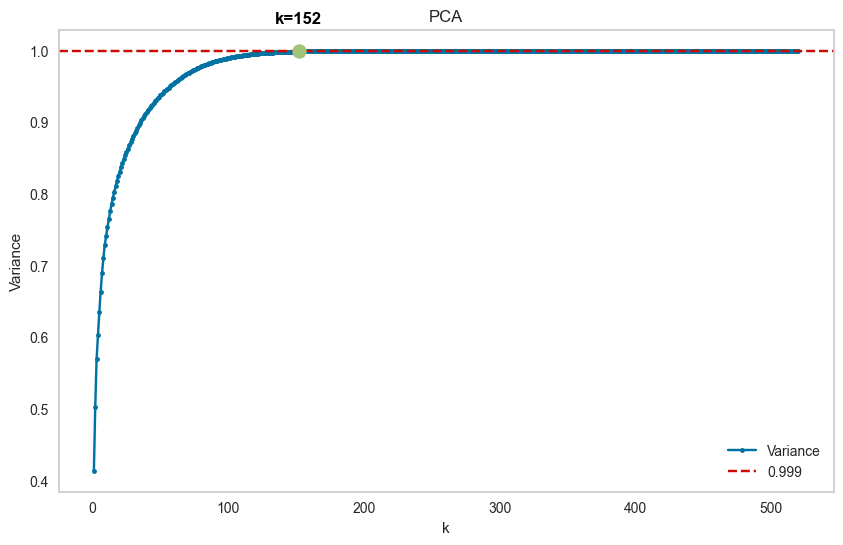

[152, 173, 233, 347, 349, 691, 701]


,Description,Value
0,Session id,369
1,Target,A0
2,Target type,Binary
3,Original data shape,"(13995, 521)"
4,Transformed data shape,"(13995, 153)"
5,Transformed train set shape,"(9796, 153)"
6,Transformed test set shape,"(4199, 153)"
7,Numeric features,520
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7704,0.8652,0.8653,0.7357,0.7953,0.5378,0.5470
1,0.7449,0.8244,0.8614,0.7073,0.7768,0.4858,0.4987
2,0.7071,0.8118,0.8455,0.6714,0.7485,0.4089,0.4246
3,0.7367,0.8323,0.8693,0.6957,0.7729,0.4688,0.4854
4,0.7378,0.8339,0.8631,0.6982,0.7720,0.4714,0.4862
5,0.7235,0.8095,0.8591,0.6840,0.7617,0.4423,0.4587
6,0.7222,0.8140,0.8214,0.6946,0.7527,0.4407,0.4488
7,0.7232,0.8157,0.8472,0.6876,0.7591,0.4419,0.4553
8,0.7436,0.8184,0.8472,0.7105,0.7729,0.4837,0.4937


Transformation Pipeline and Model Successfully Saved


,Description,Value
0,Session id,369
1,Target,A0
2,Target type,Binary
3,Original data shape,"(13995, 521)"
4,Transformed data shape,"(13995, 174)"
5,Transformed train set shape,"(9796, 174)"
6,Transformed test set shape,"(4199, 174)"
7,Numeric features,520
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7633,0.8648,0.8673,0.7264,0.7906,0.5232,0.5341
1,0.7316,0.8172,0.8673,0.6909,0.7691,0.4584,0.4755
2,0.7194,0.8214,0.8574,0.6808,0.7590,0.4336,0.4503
3,0.7520,0.8348,0.8693,0.7127,0.7832,0.5001,0.5137
4,0.7398,0.8433,0.8690,0.6986,0.7745,0.4754,0.4914
5,0.7153,0.8220,0.8512,0.6777,0.7546,0.4258,0.4417
6,0.7099,0.8119,0.8115,0.6839,0.7423,0.4160,0.4240
7,0.7406,0.8282,0.8750,0.6978,0.7764,0.4766,0.4941
8,0.7416,0.8260,0.8532,0.7061,0.7727,0.4794,0.4910


Transformation Pipeline and Model Successfully Saved


,Description,Value
0,Session id,369
1,Target,A0
2,Target type,Binary
3,Original data shape,"(13995, 521)"
4,Transformed data shape,"(13995, 234)"
5,Transformed train set shape,"(9796, 234)"
6,Transformed test set shape,"(4199, 234)"
7,Numeric features,520
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:50:30
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


KeyboardInterrupt: 

In [60]:
for file in os.listdir('./temp'):
    if file[0].isdigit():
        os.remove('./temp/'+file)


from sklearn.decomposition import PCA

# features = [col for col in dataset_s.columns if col not in ['A0','A0_p']]
dataset = dataset_s[features+['A0']]
dataset.tail()

num = 0.999

pca = PCA()
pca.fit(dataset.drop(columns=['A0']))    ### 如果做标准化，就用 data_scaled

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
k = np.argmax(cumulative_explained_variance >= num) + 1

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='.', label='Variance')
plt.axhline(y=num, color='r', linestyle='--', label=str(num))
plt.scatter(k, cumulative_explained_variance[k-1], color='g', s=100, zorder=5)
plt.annotate(f'k={k}', (k, cumulative_explained_variance[k-1]), 
             textcoords="offset points", xytext=(0, 20), ha='center', 
             fontsize=12, fontweight='bold', color='black')

plt.title('PCA')
plt.xlabel('k')
plt.ylabel('Variance')
plt.grid()
plt.legend()
plt.savefig("PCA.jpg")
plt.show()




res1 = []
res2 = []
res3 = []
res4 = []
res5 = []
res6 = []
res7 = []


resP = []
resR = []
resF = []


def unique_primes(start, n=10, k = 10 ):
    def pf(x):
        factors = set()
        while x % 2 == 0:
            factors.add(2)
            x //= 2
        i = 3
        while i*i <= x:
            while x % i == 0:
                factors.add(i)
                x //= i
            i += 2
        if x > 1:
            factors.add(x)
        return [ f for f in factors if f >= k-3 ]
    return sorted(set().union(*(pf(x) for x in range(start-n, start+1))))

# Example usage:
param_list = unique_primes(dataset_s.shape[1]-1, 10,k=k)
if k not in param_list:
    param_list = [k]+param_list
print(param_list)

for j in param_list:
    num = j
    s = setup(dataset, target = 'A0', session_id = 369, pca = True, pca_components = num)
    
    
    # abc = create_model('xgboost')  ################  xgboost,lightgbm,catboost #############
    
    # abc = create_model('xgboost', objective='binary:logitraw')  ################  不同的目标函数  #############
    
    abc = create_model('lightgbm', objective='xentlambda')  ################  不同的目标函数  #############
    
    # abc = create_model('catboost', objective='CrossEntropy')   ################  不同的目标函数  #############
    # compare_tree_models = compare_models(include = ['rf', 'xgboost', 'lightgbm', 'catboost'])

    
    abc_results = pull()
    abc_results = abc_results.loc[['Mean']]
    abc_results.to_csv('./temp/'+str(j)+f'r_{fix}.csv',index = False)
    
    final_best = finalize_model(abc)
    save_model(final_best, './temp/' + str(num) + 'x')
    data = pd.read_csv(test_path) #########  测试集文件  ########################
    data = data[features]
#     data.replace([np.inf, -np.inf], np.nan, inplace=True)   ####替换正负inf为NA
    
    predictions = predict_model(final_best, data=data) 
    
    n_preds = predictions['prediction_label'][num_xunlian:(num_xunlian+data_1_size)]    ### 取中间的数据
    n_preds = n_preds.reset_index(drop=True)                      ### 重置索引
    
    Note=open('./temp/' + str(num) + 'x.txt',mode='a')
    for i in range(0,data_1_size):         
        Note.write(str(n_preds[i]) + '\n') 
    Note.close()

    n_preds_score = predictions['prediction_score'][num_xunlian:(num_xunlian+data_1_size)]      ### 取中间的数据
    n_preds_score = n_preds_score.reset_index(drop=True)                   ### 重置索引
    
    Note=open('./temp/' + str(num) + 's.txt',mode='a')
    for i in range(0,data_1_size):         
        Note.write(str(n_preds_score[i]) + '\n') 
    Note.close()
    
    
    
    
    file_name ='./temp/Show.csv'
    df = pd.read_csv(file_name)
    path = './temp/'+str(j)+'x.txt'
    df2 = pd.read_csv(path, header=None, names=['state_x'])
    for i in range(0,data_1_size):  
        df['low'][i] = df2['state_x'][i]
   
    

    path = './temp/'+str(j)+'s.txt'
    df2 = pd.read_csv(path, header=None, names=['state_x'])
    df['score'] = 0
    for i in range(0,data_1_size):  
        df['score'][i] = df2['state_x'][i]
    df.to_csv('./temp/'+str(j)+f'x_{fix}.csv',index = False)
    
    
    
    
 

    file_name='./temp/'+  str(j) + f'x_{fix}.csv'
    data_1_new = pd.read_csv(file_name)

    aaa1 = data_1_new['volume']
    bbb1 = data_1_new['low']

    if buy == 0:
        for i in range(0,data_1_size):
            if bbb1.iloc[i] == 1:
                aaa1.iloc[i] = aaa1.iloc[i] * -1
    else:
        for i in range(0,data_1_size):
            if bbb1.iloc[i] == 0:
                aaa1.iloc[i] = aaa1.iloc[i] * -1

    for i in range(1,data_1_size):
        data_1_new['high'][i] = sum(data_1_new['volume'][0:(i+1)])

    data_1_new['high'][0] = data_1_new['volume'][0]

    for i in range(0,data_1_size):
        data_1_new['open'][i] = rrr * data_1_new['high'][i] / m


        
######################################################################################################


    wp_win = data_1_new['volume'] > 0
    wp_lost = data_1_new['volume'] < 0
    wp_nothing = data_1_new['volume'] == 0

    ### 满足条件的数量

    wp_win_a = wp_win.sum()            
    wp_lost_a = wp_lost.sum()
    wp_nothing_a = wp_nothing.sum()


    ### 满足条件的数据之和

    rrr_win = data_1_new[wp_win]['volume'].sum()
    rrr_lost = data_1_new[wp_lost]['volume'].sum()




    ##############################################################################################
    # 计算回撤数据，给到 down 列
    
    data_1_new['down'] = 0

    log = data_1_new['open'].iloc[0]

    for i in range(1,len(data_1_new)):

        if data_1_new['open'].iloc[i] < log:
            data_1_new['down'].iloc[i] = data_1_new['open'].iloc[i] - log
        else:
            log = data_1_new['open'].iloc[i]
        
    
    ##############################################################################################
    # 计算回撤面积，给到downarea列
    
    downarea = sum(data_1_new['down'])
    
    
    
    
    ##############################################################################################
    
    
    
    
    
    # 增加二级模型用到的列
    
    data_1_new['re'] = 0
    for i in range(1,len(data_1_new)):
        data_1_new['re'].iloc[i] = (data_1_new['close'].iloc[i] - data_1_new['close'].iloc[i-1]) / data_1_new['close'].iloc[i-1] * 100
        
    
    
    data_1_new['real'] = 0
    for i in range(1,len(data_1_new)):
        if data_1_new['close'].iloc[i] < data_1_new['close'].iloc[i-1]:
            data_1_new['real'].iloc[i] = 0
        else:
            data_1_new['real'].iloc[i] = 1
            
            
            
    data_1_new['real_lab'] = 'G'
    for i in range(1,len(data_1_new)):
        if buy == 0:
            if data_1_new['low'].iloc[i] != data_1_new['real'].iloc[i]:
                data_1_new['real_lab'].iloc[i] = 'G'
            else:
                data_1_new['real_lab'].iloc[i] = 'N'
        else:
            if data_1_new['low'].iloc[i] == data_1_new['real'].iloc[i]:
                data_1_new['real_lab'].iloc[i] = 'G'
            else:
                data_1_new['real_lab'].iloc[i] = 'N'
            
            
    file_name ='./temp/Show.csv'
    df = pd.read_csv(file_name)        
    data_1_new['show'] = df['low']
    
    
    
    data_1_new['show_lab'] = 'G'
    for i in range(1,len(data_1_new)):        
        if data_1_new['low'].iloc[i] == data_1_new['show'].iloc[i]:
            data_1_new['show_lab'].iloc[i] = 'G'
        else:
            data_1_new['show_lab'].iloc[i] = 'N'

        
      
    
    ##############################################################################################
    
    ### 计算夏普与索提诺
    
    data_1_new['re_real'] = 0
    for i in range(1,len(data_1_new)):
        if sell == 0:
            if data_1_new['low'].iloc[i] == 0:
                data_1_new['re_real'].iloc[i] = data_1_new['re'].iloc[i] * -1
            else:
                data_1_new['re_real'].iloc[i] = data_1_new['re'].iloc[i]
        else:
            if data_1_new['low'].iloc[i] == 1:
                data_1_new['re_real'].iloc[i] = data_1_new['re'].iloc[i] * -1
            else:
                data_1_new['re_real'].iloc[i] = data_1_new['re'].iloc[i]
    
    sharpe = round(data_1_new['re_real'][1:].mean() / data_1_new['re_real'][1:].std() * 100,4)
    
    sortino = round(data_1_new['re_real'][1:].mean() / (data_1_new['re_real'][1:][data_1_new['re_real'][1:] < 0]).std() * 100,4)
    
    ##############################################################################################
    
    
    
    
    
    
    data_1_new.to_csv('./temp/'+str(j)+f'x_{fix}.csv',index = False)
    
    
    
    
    s = np.argmax((np.maximum.accumulate(data_1_new['open']) - data_1_new['open'])) 
    if s == 0:
        e = 0
    else:
        e = np.argmax(data_1_new['open'][:s])  
    maxdrawdown = data_1_new['open'][e] - data_1_new['open'][s] # 最大回撤
    drawdown_days = s - e # 回撤持续周期数
    
    
    
    
    start_DAY = data_1_new.index[s] #开始回撤的日期
    end_DAY = data_1_new.index[e] #结束回撤的日期
    start_net_value = data_1_new[data_1_new.index == start_DAY]['open'].values[0] #开始回撤的净值
    end_net_value = data_1_new[data_1_new.index == end_DAY]['open'].values[0] #结束回撤的净值
    fig=plt.figure(figsize=(20,11))  
    plt.plot(data_1_new['eob'], data_1_new['open'])
    plt.plot([start_DAY, end_DAY], [start_net_value, end_net_value], linestyle='--', color='r')

    plt.xticks(range(0,data_1_size,int(data_1_size/m_size))) 

    plt.legend(['All:' + str(round(data_1_new['open'].iloc[-1]*100,2)) + '%' +
                '   ' + str(m_size) + 'm'
                '   Year:'+ str(round(data_1_new['open'].iloc[-1]/m_size*100*12,2)) + '%' +
                '   CalmarY:'+ str(round((data_1_new['open'].iloc[-1]/m_size*100*12)/(maxdrawdown*100),2)) +
                '   WP:' + str(round(wp_win_a/(wp_win_a + wp_lost_a)*100,2)) + '%' +
                '   RRR:' + str(round(rrr_win/(rrr_win+abs(rrr_lost))*100,2)) + '%' + ' / ' + str(round(rrr_win/abs(rrr_lost),2)) +
                '   T/N:' + str(wp_win_a + wp_lost_a ) + ' / ' + str(wp_nothing_a) +
                '   Sharpe:' + str(sharpe) +
                '   Sortino:' + str(sortino) +
                '   Accuracy:' + str(abc_results['Accuracy'][0]) +
                '   AUC:' + str(abc_results['AUC'][0]) +
                '   Recall:' + str(abc_results['Recall'][0]) +
                '   Prec:' + str(abc_results['Prec.'][0]) +
                '   F1:' + str(abc_results['F1'][0]) +
                '   Kappa:' + str(abc_results['Kappa'][0]) +
                '   MCC:' + str(abc_results['MCC'][0]),

                'MD:'+ str(round(maxdrawdown*100,2)) + '%' +
                '   DA:'+ str(round(downarea,4)) + '%' +
                '   MDT:' + str(drawdown_days)+
                '   Date:' + str(data_1_new['eob'].iloc[e]) + ' - ' + str(data_1_new['eob'].iloc[s])] ,

                loc='upper left',fontsize = 11)   ########### 默认是10
    
    
    plt.plot(data_1_new['eob'], data_1_new['down'], color='#ec700a')   ### 桔色
    plt.fill_between(data_1_new['eob'], data_1_new['down'], 0, where=(data_1_new['down']<0), facecolor='#FF0000', alpha=0.1)   
    plt.xticks(range(0,data_1_size,int(data_1_size/m_size)))                                           ### 红色 + 透明度
           

    
    fig.autofmt_xdate()
    plt.grid(1)
    plt.savefig("./temp/" + str(j) + "sy.jpg")
    plt.close()


    fig=plt.figure(figsize=(20,10))  
    plt.plot(data_1_new['eob'], data_1_new['high'])
    plt.xticks(range(0,data_1_size,int(data_1_size/m_size)))     ### 最后一个是间隔
    fig.autofmt_xdate()
    plt.grid(1)
    plt.savefig("./temp/" + str(j) + "p.jpg")
    plt.close()
    

    
    ##############################################################################################
    
    
    pp = abc_results['Prec.'][0]
    resP.append({
        'Prec_no': j,
        'max_Prec': pp
    })
    
    rr = abc_results['Recall'][0]
    resR.append({
        'Recall_no': j,
        'max_Recall': rr
    })
    
    ff = abc_results['F1'][0]
    resF.append({
        'F1_no': j,
        'max_F1': ff
    })
    

    
    
    ##############################################################################################
    
        

    max_all = round(data_1_new['open'].iloc[-1]*100,2)
    max_no = j

    res1.append({
        'All_no': max_no,
        'max_All': max_all
    })



    max_CalmarY = round((data_1_new['open'].iloc[-1]/m_size*100*12)/(maxdrawdown*100),2)
    
    res2.append({
        'CalmarY_no': max_no,
        'max_CalmarY': max_CalmarY
    })
    
    
    
    res3.append({
        'Downarea_no': max_no,
        'min_Downarea': downarea
    })
          
        
    max_wp = round(wp_win_a/(wp_win_a + wp_lost_a)*100,2)
    
    res4.append({
        'WP_no': max_no,
        'max_WP': max_wp
    })
    
    
    max_rrr = round(rrr_win/(rrr_win+abs(rrr_lost))*100,2)
    
    res5.append({
        'RRR_no': max_no,
        'max_RRR': max_rrr
    })
    
    
    res6.append({
        'Sharpe_no': max_no,
        'max_Sharpe': sharpe
    })
        
        
    res7.append({
        'Sortino_no': max_no,
        'max_Sortino': sortino
    })
    

   ##############################################################################################


aaaP = pd.DataFrame(resP)
aaaR = pd.DataFrame(resR)
aaaF = pd.DataFrame(resF)


bbbP = aaaP.sort_values(by="max_Prec",ascending=False)
bbbR = aaaR.sort_values(by="max_Recall",ascending=False)
bbbF = aaaF.sort_values(by="max_F1",ascending=False)


bbbP = bbbP.reset_index(drop=True)
bbbR = bbbR.reset_index(drop=True)
bbbF = bbbF.reset_index(drop=True)

bbbP['Recall_no'] = bbbR['Recall_no']
bbbP['max_Recall'] = bbbR['max_Recall']
bbbP['F1_no'] = bbbF['F1_no']
bbbP['max_F1'] = bbbF['max_F1']

bbbP.to_csv("./temp/Best_2.csv",index = False)


   ##############################################################################################



aaa1 = pd.DataFrame(res1)
aaa2 = pd.DataFrame(res2)
aaa3 = pd.DataFrame(res3)
aaa4 = pd.DataFrame(res4)
aaa5 = pd.DataFrame(res5)
aaa6 = pd.DataFrame(res6)
aaa7 = pd.DataFrame(res7)


bbb1 = aaa1.sort_values(by="max_All",ascending=False)       ### 由大到小排序
bbb2 = aaa2.sort_values(by="max_CalmarY",ascending=False)    
bbb3 = aaa3.sort_values(by="min_Downarea",ascending=False)     
bbb4 = aaa4.sort_values(by="max_WP",ascending=False)    
bbb5 = aaa5.sort_values(by="max_RRR",ascending=False)    
bbb6 = aaa6.sort_values(by="max_Sharpe",ascending=False)    
bbb7 = aaa7.sort_values(by="max_Sortino",ascending=False)   



bbb1 = bbb1.reset_index(drop=True)
bbb2 = bbb2.reset_index(drop=True)
bbb3 = bbb3.reset_index(drop=True)
bbb4 = bbb4.reset_index(drop=True)
bbb5 = bbb5.reset_index(drop=True)
bbb6 = bbb6.reset_index(drop=True)
bbb7 = bbb7.reset_index(drop=True)




bbb1['CalmarY_no'] = bbb2['CalmarY_no']
bbb1['max_CalmarY'] = bbb2['max_CalmarY']
bbb1['Downarea_no'] = bbb3['Downarea_no']
bbb1['min_Downarea'] = bbb3['min_Downarea']
bbb1['WP_no'] = bbb4['WP_no']
bbb1['max_WP'] = bbb4['max_WP']
bbb1['RRR_no'] = bbb5['RRR_no']
bbb1['max_RRR'] = bbb5['max_RRR']
bbb1['Sharpe_no'] = bbb6['Sharpe_no']
bbb1['max_Sharpe'] = bbb6['max_Sharpe']
bbb1['Sortino_no'] = bbb7['Sortino_no']
bbb1['max_Sortino'] = bbb7['max_Sortino']



bbb1.to_csv("./temp/Best_1.csv",index = False)


In [145]:
import sys
sys.path.append('E:/dragon/GA_Shane')
from functions import * 
X = dataset_s
feature = 'h2l'
w = 20 
dataset_s['test']=rolling_apply(lpcc,(X[feature]-X[feature].rolling(w).mean() )/ X[feature].rolling(w).std(), w, 6, 1)
dataset_s['test11']=rolling_apply(lpcc,(X[feature]-X[feature].rolling(w).mean() )/ X[feature].rolling(w).std(), w, 6, 5)

In [154]:
# Example usage
res = []
for col in tqdm(['test','test11']):
    x = dataset_s['A0']  # Target (should be categorical)
    y = dataset_s[col].fillna(0)   # Feature (continuous)
    ig = 1-information_gain_categorical_target(x, y, bins=10)
    ic = np.corrcoef(x,y)[0, 1]
    res.append({'col': col, 'ig': ig, 'ic': ic})


100%|██████████| 2/2 [00:00<00:00, 133.28it/s]


In [144]:
res

[{'col': 'test', 'ig': 0.0013112969868800395, 'ic': -0.010931835994258466},
 {'col': 'test11', 'ig': 0.0010964383460153604, 'ic': 0.01408304810953166}]

In [4]:
def _s(X,col='close', target='state'):
    X = X[[col,target]].dropna()
    X = X.iloc[:int(len(X)/3)]
    x = X[col]
    x = (x-x.mean())/x.std()
    y = X[target]
    ic = np.corrcoef(x,y)[0, 1]
    ig = information_gain_categorical_target(y, x, bins=2)
    return ic,ig  

In [1]:
import os 
import numpy as np
import pandas as pd
import polars as pl 
import warnings 

import glob
import tsfel
from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

from functions import *

warnings.filterwarnings('ignore')

code = 'RB'
roll = 5
label = 30
test_start = '2023-01-01'
fix = 513

part = '20250421_155054_2XCKt6'
dir = f'E:/dragon/GA_Shane/outputs/{part}'

window_size = 10 
cfg = tsfel.get_features_by_domain(['statistical'])

""" 
Data 
"""
file_name_1 = glob.glob(os.path.join(dir, '*_output_axis.csv'))[0]
df = pd.read_csv(file_name_1).sort_values('eob')

file_name_2 = glob.glob(os.path.join(dir, f'*_output_axis_Label_{str(fix)}.csv'))[0]
df_label = pd.read_csv(file_name_2)


df = df.merge(df_label[['datelist','state','state_p']], left_on='eob',right_on='datelist',how='left')
df_label = df[['eob','state','state_p']]
df.drop(columns=['datelist'],inplace=True)

""" 
Feature Generation
"""
features = ['open','high','low','close','volume']
X = df.copy(deep=True)[['state','state_p']+features]
X.loc[:,['state','state_p']] = X.loc[:,['state','state_p']].shift(-1)
X = X.dropna()
print("Original X.shape: ", X.shape)

price_features = ['open','high','low','close']
volume_features = ['volume',]

print('base feature :', features)

for feature in volume_features:
    X[feature] = X[feature] + 1e-5 # avoid 0 volume

for feature in features:
    X[feature] = np.log(X[feature])
print(X.head())

Original X.shape:  (15070, 7)
base feature : ['open', 'high', 'low', 'close', 'volume']
   state   state_p      open      high       low     close     volume
4    1.0  0.500000  8.417740  8.425819  8.416355  8.424795  12.884040
5    1.0  0.498228  8.424738  8.428205  8.424639  8.426732  13.702723
6    1.0  0.116074  8.426702  8.432912  8.424520  8.430745  13.296404
7    0.0  0.499999  8.430642  8.433409  8.419632  8.422519  13.088467
8    0.0  0.496488  8.422068  8.422192  8.382068  8.388510  11.313083


In [2]:
import numpy as np
import antropy as ant
np.random.seed(1234567)
x = np.random.normal(size=3000)
print(ant.perm_entropy(x, normalize=True))
print(ant.spectral_entropy(x, sf=100, method='welch', normalize=True))
print(ant.svd_entropy(x, normalize=True))
print(ant.app_entropy(x))
print(ant.sample_entropy(x))
print(ant.hjorth_params(x))
print(ant.num_zerocross(x))
print(ant.lziv_complexity('01111000011001', normalize=True))

0.9995371694290869
0.9940882825422431
0.9999110978316078
2.015221318528564
2.198595813245399
(1.4313385010057378, 1.215335712274099)
1531
1.3597696150205727


In [10]:
X['test'] = X['close'].diff(7)
_s(X,'test')

(0.5884927820314702, 0.1332321168649655)

In [8]:
import numpy as np
import antropy as ant
np.random.seed(1234567)
x = np.random.normal(size=3000)
print(ant.perm_entropy(x, normalize=True))
print(ant.spectral_entropy(x, sf=100, method='welch', normalize=True))
print(ant.svd_entropy(x, normalize=True))
print(ant.app_entropy(x))
print(ant.sample_entropy(x))
print(ant.hjorth_params(x))
print(ant.num_zerocross(x))
print(ant.lziv_complexity('01111000011001', normalize=True))

0.9995371694290869
0.9940882825422431
0.9999110978316078
2.015221318528564
2.198595813245399
(1.4313385010057378, 1.215335712274099)
1531
1.3597696150205727


In [9]:
ant.perm_entropy(np.array(X['close']), normalize=True)

0.9604541901286103

In [398]:
x = np.array((X['high']+X['high'].rolling(5).std()).diff())
X['test'] = x 
_s(X,'test')

(0.39251099839700176, 0.0017995571121945941)

In [369]:
x = np.array((X['high']+X['high'].diff().rolling(5).std()))
x = np.array((X['low']+X['low'].diff().rolling(5).std()))
X['perm_entropy'] = rolling_apply(ant.perm_entropy,x,10, 3,1,True)

_s(X,'perm_entropy')

(0.11743548989028008, 0.008604147324991596)

In [ ]:
x = np.array((X['high']+X['high'].diff().rolling(10).std()))
x = np.array((X['low']+X['low'].diff().rolling(10).std()))

X['spectral_entropy'] = rolling_apply(ant.spectral_entropy,x, 10, 1,'welch')
_s(X,'spectral_entropy')

(0.1074658319337152, 0.004641200748476071)

In [ ]:
x = np.array(X['high'].rolling(3).max())
x = np.array(X['low'].rolling(3).min())

X['svd_entropy'] = rolling_apply(ant.svd_entropy,x,10,3,1,True)
_s(X,'svd_entropy')

(-0.12322811114276916, 5.359873893906464e-05)

In [477]:
x = np.array(X['high'].rolling(3).max().diff().cumsum())
x = np.array(X['low'].rolling(3).min().diff().cumsum())

X['app_entropy'] = np.nan  # Initialize with NaNs
valid_mask = ~np.isnan(x)
X.loc[valid_mask, 'app_entropy'] = rolling_apply(ant.app_entropy, x[valid_mask],20)
_s(X, 'app_entropy')

(0.1433525724291832, 0.003438817733421029)

In [547]:
w = 20
# x = np.array((1/(X['volume'])).cumsum())
x = np.array(X['high'].diff(5))

X['sample_entropy'] = np.nan  # Initialize with NaNs
valid_mask = ~np.isnan(x)
X.loc[valid_mask, 'sample_entropy'] = rolling_apply(ant.sample_entropy, x[valid_mask], w,2)
X['sample_entropy'] = X['sample_entropy'].replace({np.inf:np.nan}).fillna(X['sample_entropy'].rolling(w).max())
_s(X, 'sample_entropy','state')

(-0.10867203770109206, 0.006956169586977756)

In [592]:
w = 10
x = np.array((X['low'].rolling(5).max()).diff().cumsum())


def hjorth_params0(x):
    return ant.hjorth_params(x)[0]

def hjorth_params1(x):
    return ant.hjorth_params(x)[1]

X['hjorth_params'] = np.nan 
valid_mask = ~np.isnan(x)
X.loc[valid_mask, 'hjorth_params'] = rolling_apply(hjorth_params1, x[valid_mask], w)
_s(X, 'hjorth_params','state')

(-0.05674065252555827, 6.954131573277955e-05)

In [628]:
w = 10
# x = np.array(X['high'].diff())
# x = np.array(X['close'].diff())
x = np.array((X['close'].rolling(5).max()).diff())
x = np.array((X['high'].rolling(5).max()).diff())
# x = np.array((X['low'].rolling(5).max()).diff())


X['num_zerocross'] = rolling_apply(ant.num_zerocross,x,w,)
_s(X,'num_zerocross')

(-0.12449730874405661, 0.0018616024844065882)

In [21]:
import scipy
w = 10
x = np.array(X['close'].diff(5).cumsum())

X['num_zerocross'] = rolling_apply(scipy.stats.skew,x,w,)
_s(X,'num_zerocross')

(0.29698183902792014, 0.03669297783255909)

In [ ]:
w = 5
x = np.array(X['close'].diff(9).cumsum())

X['skew'] = rolling_apply(scipy.stats.skew,x,w,)
_s(X,'skew')

(0.3661843942864122, 0.06615163339763874)

In [ ]:
w = 5
x = np.array(X['close'].diff().cumsum())

X['kurtosis'] = rolling_apply(scipy.stats.kurtosis,x,w,)
_s(X,'kurtosis')

(-0.0016791415978531122, 4.5198982728145154e-05)

In [ ]:
w = 10
x = np.array(X['close'].diff(7).cumsum())

X['kstat'] = rolling_apply(scipy.stats.kstat,x, w,3)

_s(X,'kstat')

(0.17506276871042534, 0.009969147537358669)

In [86]:
w = 20
x = np.array(X['close'].diff().cumsum())
x = np.array(X['high'].diff().cumsum())
x = np.array(X['open'].diff().cumsum())
x = np.array(X['low'].diff().cumsum())
x = np.array(X['state_p'].shift(1).diff())
x = np.array(X['close'].diff())
x = np.array(X['close'].diff(7))
# x = np.array(X['close'].diff(10))

X['rankdata'] = rolling_apply_last(scipy.stats.rankdata,x, w,)

_s(X,'rankdata')

(0.5436046548672693, 0.11335807809726561)

(0.4310976209610082, 0.06720779807604493)